In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import cross_val_score, KFold
from src.data_processing.pipeline import DataPipeline
from src.models.model import InvestorRegressor
from src.models.trainer import Trainer
from src.models.decision import DecisionSynthesizer

Training set: (112, 21), Test set: (48, 21)


,count,mean,std,min,25%,50%,75%,max
follow_on_rate,112.0,0.341505,0.120538,0.10,0.237500,0.360000,0.400000,0.670000
age_years,112.0,2.657158,1.904859,0.00,1.812457,1.812457,3.649555,10.811773
pct_seed,112.0,0.506695,0.287126,0.10,0.150000,0.691489,0.750000,0.900000
pct_early,112.0,0.280056,0.140397,0.05,0.200000,0.255319,0.350000,0.700000
pct_growth,112.0,0.213250,0.195773,0.00,0.050000,0.100000,0.300000,0.750000
stage_risk,112.0,0.714286,0.145105,0.40,0.600000,0.700000,0.800000,1.000000
dealflow_enc,112.0,0.714286,0.764394,0.00,0.000000,1.000000,1.000000,2.000000
market__saas,112.0,0.767857,0.424097,0.00,1.000000,1.000000,1.000000,1.000000
market__fintech,112.0,0.750000,0.434959,0.00,0.750000,1.000000,1.000000,1.000000
market__ai,112.0,0.500000,0.502247,0.00,0.000000,0.500000,1.000000,1.000000


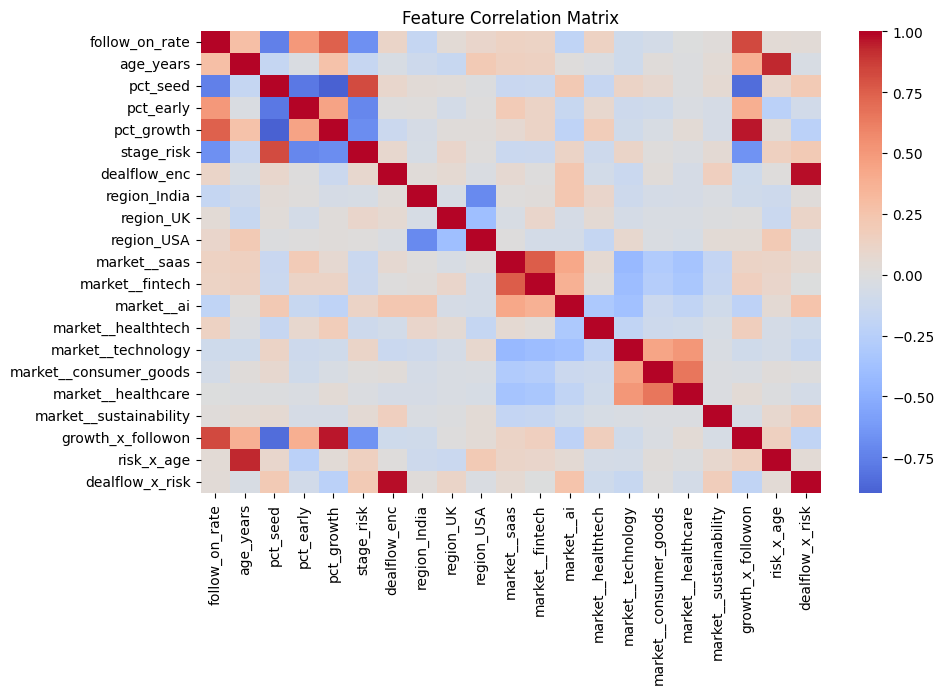

In [8]:
#@title Data Loading and Preprocessing
pipe = DataPipeline('data/cleaned_data.csv')
pipe.load().transform()

X_train, X_test, y_train, y_test = pipe.split()

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
display(X_train.describe().T)

# Quick correlation overview
plt.figure(figsize=(10,6))
sns.heatmap(X_train.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()


In [13]:
#@title Train and Evaluate the Model
model = InvestorRegressor('ridge')
trainer = Trainer(model)
trainer.fit(X_train, y_train)

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model.pipe, X_train, y_train, cv=cv, scoring='r2')
print(f"R² (CV 5-folds): {scores.mean():.3f} ± {scores.std():.3f}")

# Evaluation on test
eval_results = trainer.evaluate(X_test, y_test)
print("Evaluation results:", eval_results)


R² (CV 5-folds): 0.621 ± 0.107
Evaluation results: {'rmse': 139765296.9138421, 'r2': -0.7273928002622421}


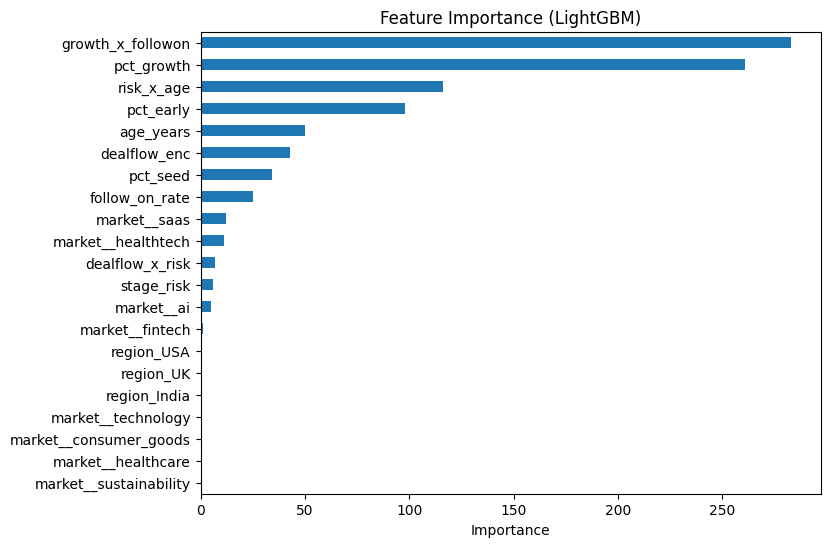

In [10]:
#@title Feature Importance
importances = model.pipe['model'].feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title("Feature Importance (LightGBM)")
plt.xlabel("Importance")
plt.show()


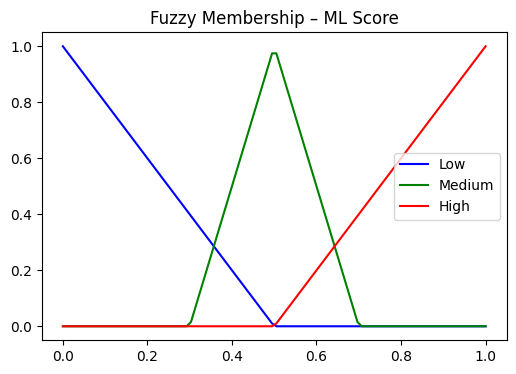

In [11]:
#@title Fuzzy logic
from src.models.fuzzy_layer import build_fuzzy_system
import skfuzzy as fuzz

# Visualize fuzzy membership for ML score
ml_score = np.linspace(0, 1, 100)
low = fuzz.trimf(ml_score, [0, 0, 0.5])
medium = fuzz.trimf(ml_score, [0.3, 0.5, 0.7])
high = fuzz.trimf(ml_score, [0.5, 1, 1])

plt.figure(figsize=(6,4))
plt.plot(ml_score, low, 'b', label='Low')
plt.plot(ml_score, medium, 'g', label='Medium')
plt.plot(ml_score, high, 'r', label='High')
plt.title('Fuzzy Membership – ML Score')
plt.legend()
plt.show()


,ml_score,fuzzy_score,final_score
0,NaN,43.528288,NaN
1,NaN,32.730363,NaN
2,0.907206,60.935867,0.788067
3,NaN,57.249815,NaN
4,NaN,57.249815,NaN


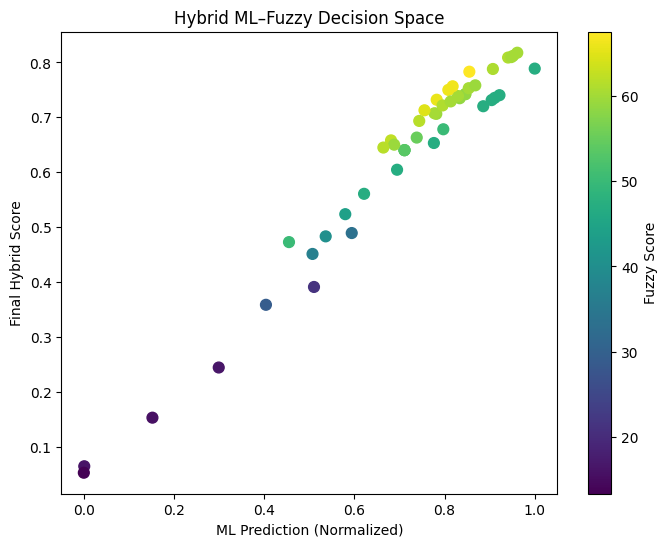

Final scores exported: data/final_investor_scores.csv


In [14]:
#@title Decision Synthesis
df_ready = trainer.export_ml_scores(X_test, pipe.df_feat)
synth = DecisionSynthesizer()

results = []
for _, row in df_ready.iterrows():
    res = synth.synthesize_one(row.to_dict(), row['ml_score'])
    results.append({**row.to_dict(), **res})

final_df = pd.DataFrame(results)

# Display preview
display(final_df[['ml_score', 'fuzzy_score', 'final_score']].head())

# Visualization
plt.figure(figsize=(8,6))
plt.scatter(final_df['ml_score'], final_df['final_score'], 
            c=final_df['fuzzy_score'], cmap='viridis', s=60)
plt.colorbar(label="Fuzzy Score")
plt.xlabel("ML Prediction (Normalized)")
plt.ylabel("Final Hybrid Score")
plt.title("Hybrid ML–Fuzzy Decision Space")
plt.show()

# Export
final_df.to_csv('data/final_investor_scores.csv', index=False)
print("Final scores exported: data/final_investor_scores.csv")
